# Predictive Signals for Volatility: Time Series Analysis

Classification analysis using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data for 'bitcoin'
* Bitcoin volatility index VXBT
* Bitcoin price data

In [1]:
%config IPCompleter.greedy=True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)

## Twitter data

### Getting tweets from Google Cloud Storage (left for reference)

In [4]:
from google.cloud import firestore
import json

In [5]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)

### Load tweets from tweet dataset CSV

In [170]:
tweets_df = pd.read_csv('../datasets/tweets-full.csv')
tweets_df['created'] = pd.to_datetime(tweets_df['created'])
tweets_df

,created,tweet_id,compound
0,2019-05-01 00:00:00+00:00,1123376489108529153,-0.2960
1,2019-05-01 00:00:01+00:00,1123376492065558529,-0.5093
2,2019-05-01 00:00:01+00:00,1123376492287754243,0.8074
3,2019-05-01 00:00:01+00:00,1123376492682076162,0.0772
4,2019-05-01 00:00:02+00:00,1123376495953682437,0.0000
...,...,...,...
3792655,2020-06-09 23:42:08+00:00,1270501462519447556,-0.5859
3792656,2020-06-09 23:42:54+00:00,1270501655759503363,0.0000
3792657,2020-06-09 23:42:54+00:00,1270501657810534401,0.5859
3792658,2020-06-09 23:43:44+00:00,1270501868301684736,0.0000


### Calculate tweet volume

In [7]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'compound'])
tweets_time_df

,tweet_id,compound
created,,
2019-05-01 00:00:00+00:00,1123376489108529153,-0.2960
2019-05-01 00:00:01+00:00,1123376492065558529,-0.5093
2019-05-01 00:00:01+00:00,1123376492287754243,0.8074
2019-05-01 00:00:01+00:00,1123376492682076162,0.0772
2019-05-01 00:00:02+00:00,1123376495953682437,0.0000
...,...,...
2020-06-09 23:42:08+00:00,1270501462519447556,-0.5859
2020-06-09 23:42:54+00:00,1270501655759503363,0.0000
2020-06-09 23:42:54+00:00,1270501657810534401,0.5859


In [8]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='5Min'))
tweet_volume = tweet_grouped.count()
tweet_volume

,tweet_id,compound
created,,
2019-05-01 00:00:00+00:00,67,67
2019-05-01 00:05:00+00:00,31,31
2019-05-01 00:10:00+00:00,26,26
2019-05-01 00:15:00+00:00,30,30
2019-05-01 00:20:00+00:00,30,30
...,...,...
2020-06-09 23:20:00+00:00,23,23
2020-06-09 23:25:00+00:00,17,17
2020-06-09 23:30:00+00:00,16,16


Text(0.5, 1.0, '#bitcoin Tweets per 5 min')

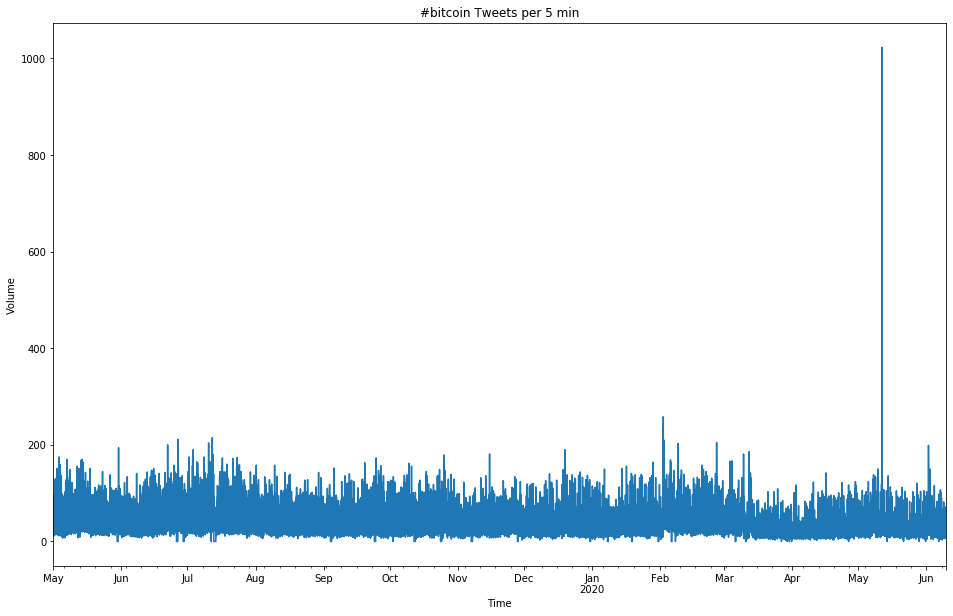

In [9]:
plot_start_date = '2019-05-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per 5 min')

Fix zeros:

In [10]:
tweet_volume['volume'] = tweet_volume['tweet_id'].replace(0, np.nan).interpolate()

Apply exponential weight mean smoothing:

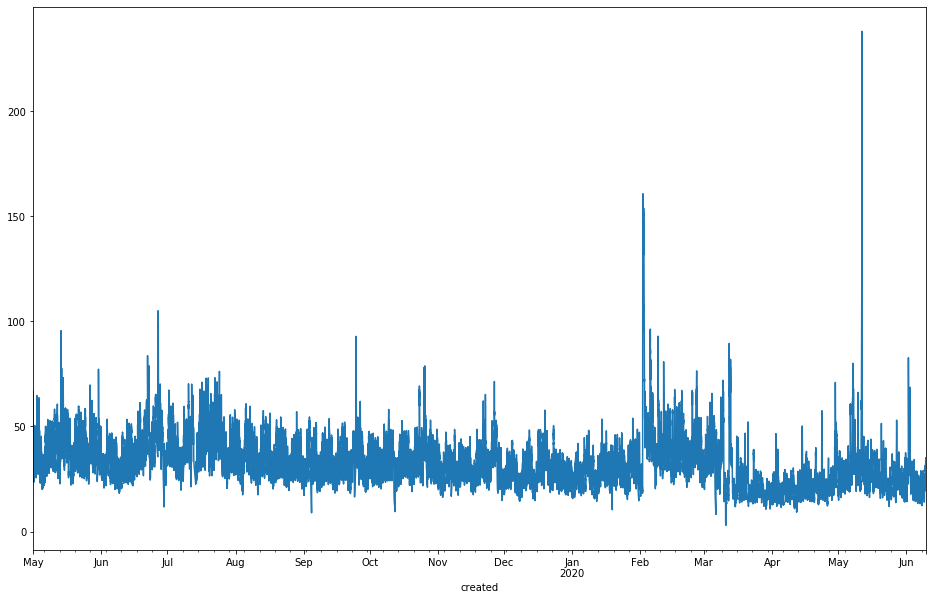

In [11]:
tweet_volume['smooth'] = tweet_volume['volume'].ewm(12).mean()
tweet_volume['smooth'].plot()

### Tweet sentiment time series

In [12]:
sentiment_time = tweet_grouped.mean()
sentiment_time

,tweet_id,compound
created,,
2019-05-01 00:00:00+00:00,1.123377e+18,0.231404
2019-05-01 00:05:00+00:00,1.123378e+18,0.018871
2019-05-01 00:10:00+00:00,1.123380e+18,0.138727
2019-05-01 00:15:00+00:00,1.123381e+18,0.149630
2019-05-01 00:20:00+00:00,1.123382e+18,0.142577
...,...,...
2020-06-09 23:20:00+00:00,1.270496e+18,0.020857
2020-06-09 23:25:00+00:00,1.270498e+18,0.019759
2020-06-09 23:30:00+00:00,1.270499e+18,0.051388


Text(0, 0.5, 'Mean Sentiment Rating')

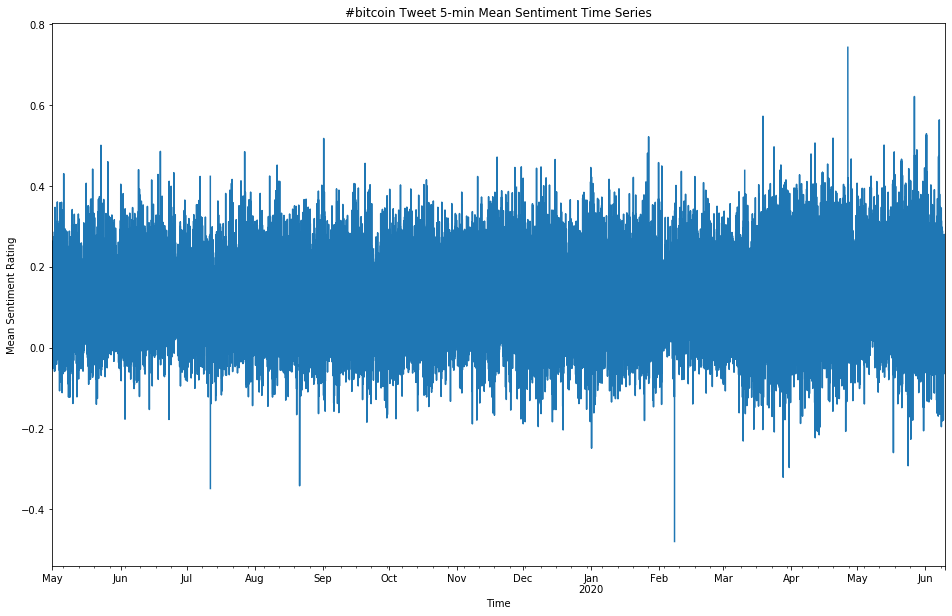

In [13]:
sentiment_time['compound'].plot()
plt.title('#bitcoin Tweet 5-min Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

Apply exponential weighted mean smoothing:

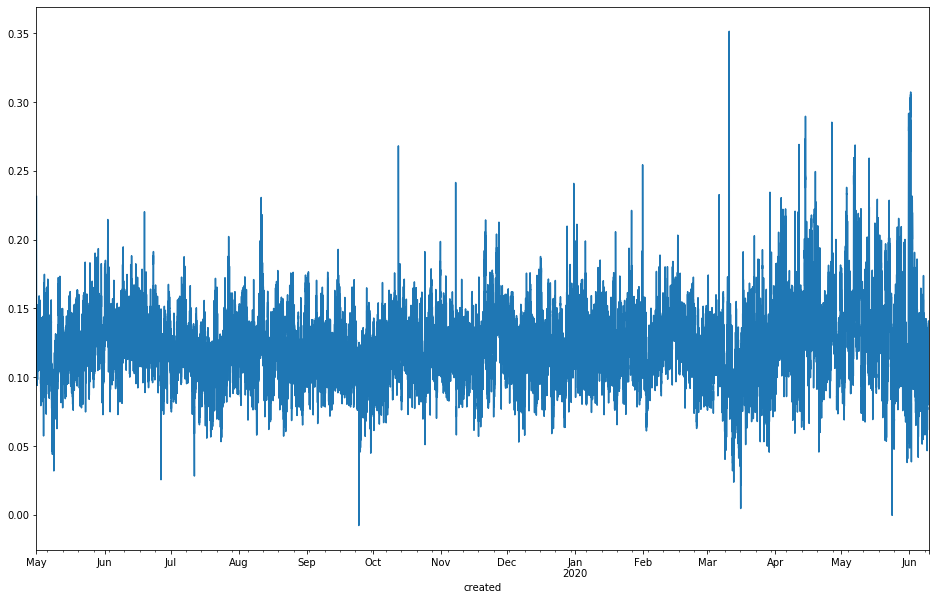

In [14]:
sentiment_time['smooth'] = sentiment_time['compound'].ewm(12).mean()
sentiment_time['smooth'].plot()

## Google Trends Data

In [15]:
from pytrends.request import TrendReq

In [16]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df

,bitcoin
date,
2015-06-21,2
2015-06-28,2
2015-07-05,2
2015-07-12,2
2015-07-19,2
...,...
2020-05-17,14
2020-05-24,13
2020-05-31,12


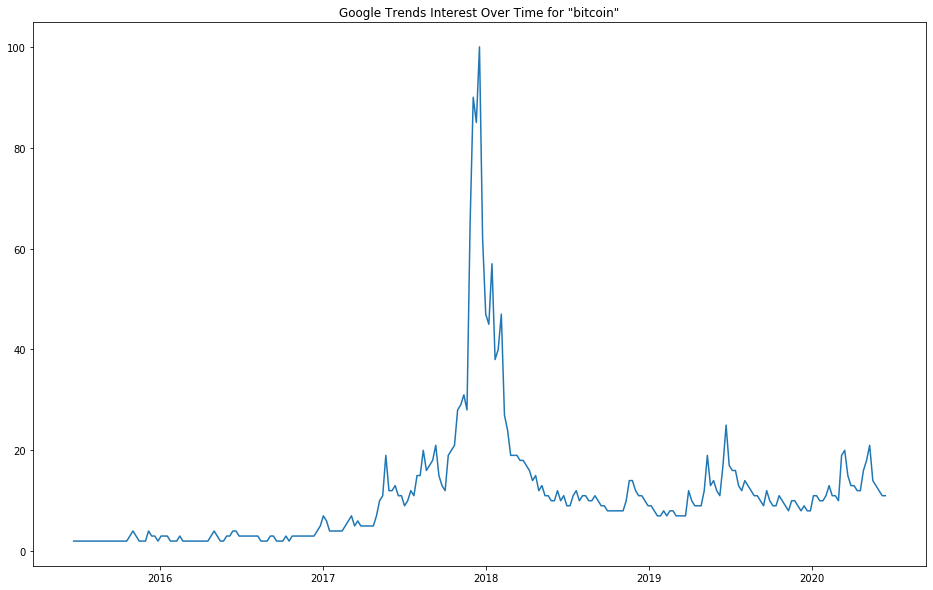

In [17]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [18]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2019, month_start=5, day_start=1, hour_start=0, year_end=2020, month_end=5, day_end=1, hour_end=0, cat=0, geo='', gprop='').drop('isPartial', axis=1).reset_index().drop_duplicates('date').set_index('date')
historical_hourly_interest_df

HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)


,bitcoin
date,
2019-05-01 00:00:00,69
2019-05-01 01:00:00,66
2019-05-01 02:00:00,64
2019-05-01 03:00:00,66
2019-05-01 04:00:00,64
...,...
2020-04-30 20:00:00,66
2020-04-30 21:00:00,66
2020-04-30 22:00:00,66


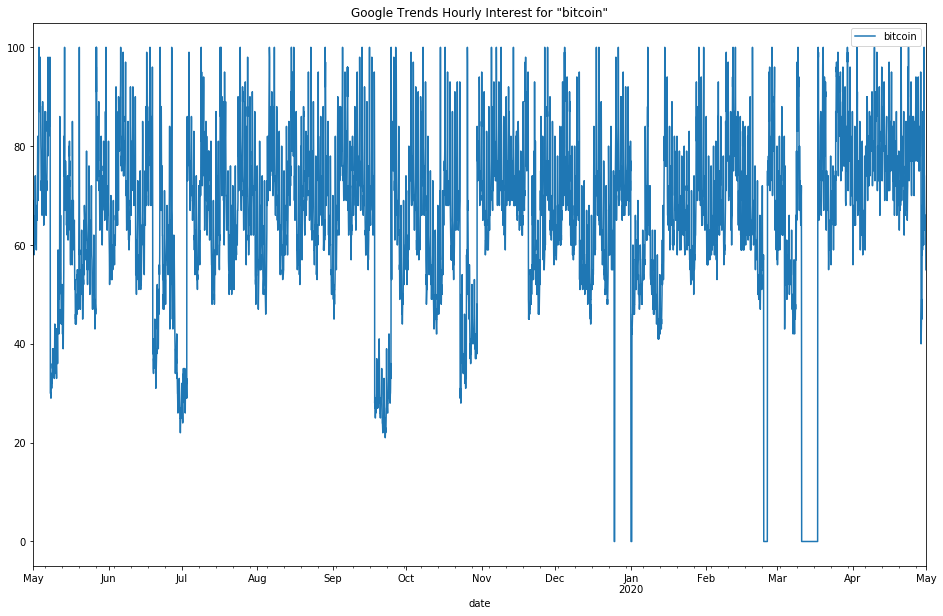

In [48]:
historical_hourly_interest_df.plot()
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

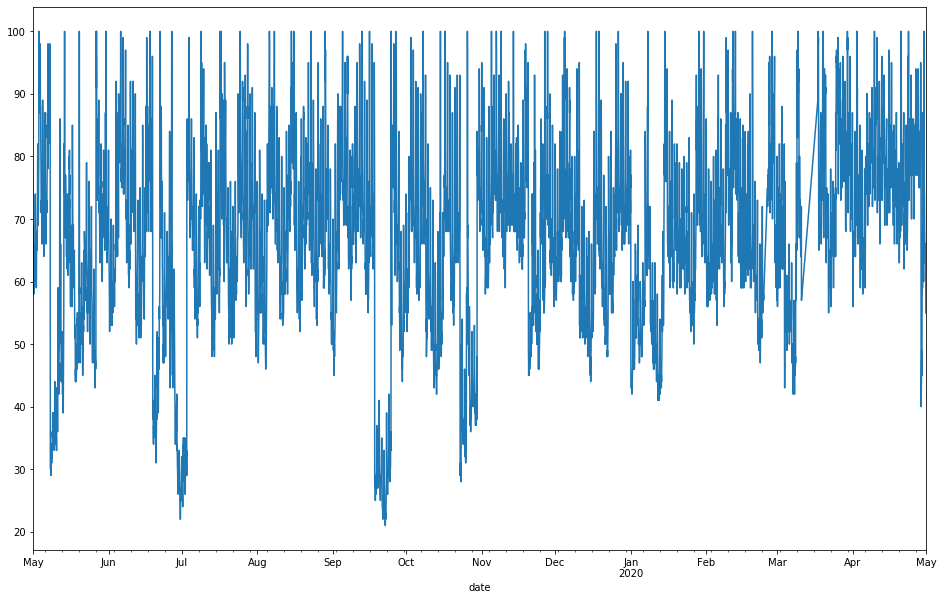

In [53]:
historical_hourly_interest_df['bitcoin_clean'] = historical_hourly_interest_df['bitcoin'].replace(0, np.nan).interpolate()
historical_hourly_interest_df['bitcoin_clean'].plot()

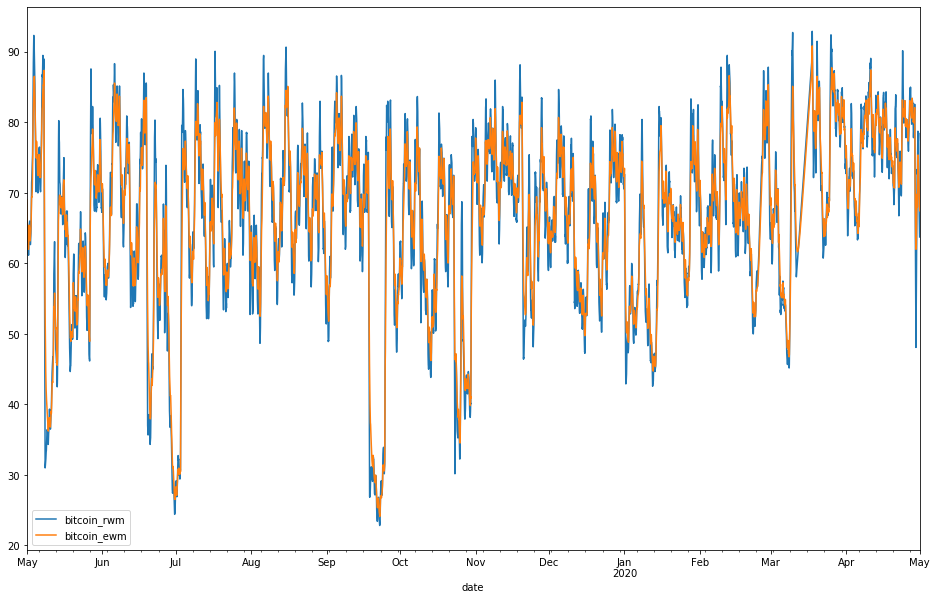

In [135]:
gtrend_df = pd.DataFrame()
gtrend_df['bitcoin_rwm'] = historical_hourly_interest_df['bitcoin_clean'].rolling(window=12).mean().resample('5Min').interpolate(method='linear')
gtrend_df['bitcoin_ewm'] = historical_hourly_interest_df['bitcoin_clean'].ewm(12).mean().resample('5Min').interpolate(method='linear')
gtrend_df.plot()

In [136]:
gtrend_df.index = gtrend_df.index.tz_localize('UTC')
gtrend_df

,bitcoin_rwm,bitcoin_ewm
date,,
2019-05-01 00:00:00+00:00,NaN,69.000000
2019-05-01 00:05:00+00:00,NaN,68.870000
2019-05-01 00:10:00+00:00,NaN,68.740000
2019-05-01 00:15:00+00:00,NaN,68.610000
2019-05-01 00:20:00+00:00,NaN,68.480000
...,...,...
2020-04-30 23:40:00+00:00,64.111111,67.813516
2020-04-30 23:45:00+00:00,64.020833,67.726938
2020-04-30 23:50:00+00:00,63.930556,67.640361


### Bitcoin price index data

In [59]:
btc_index_dbit_df = pd.read_csv('../datasets/deribit_btc_usd_index_19-05-01_20-05-31_5min.csv')
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time')
btc_index_dbit_df

,Price
Date and Time,
2019-05-01 00:00:00+00:00,5269.46
2019-05-01 00:05:00+00:00,5268.33
2019-05-01 00:10:00+00:00,5272.10
2019-05-01 00:15:00+00:00,5277.00
2019-05-01 00:20:00+00:00,5289.70
...,...
2020-05-31 23:35:00+00:00,9433.96
2020-05-31 23:40:00+00:00,9410.57
2020-05-31 23:45:00+00:00,9418.37


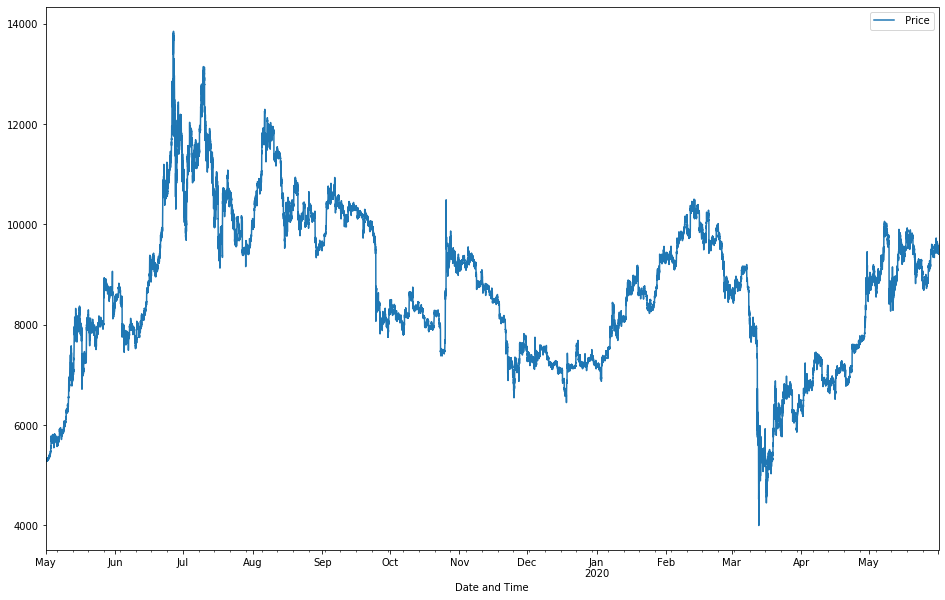

In [61]:
btc_index_dbit_df.plot()

### Volatility index data

In [379]:
with open('../datasets/capi_vxbt.json') as f:
    dat = f.read()
    
capi_vxbt_df = pd.DataFrame.from_dict(json.loads(dat), orient='index', columns=['vxbt', 'gvxbt', 'avxbt'])
capi_vxbt_df.index = pd.to_datetime(capi_vxbt_df.index).tz_localize('UTC')
capi_vxbt_df

,vxbt,gvxbt,avxbt
2019-05-01 00:00:00+00:00,62.345296,61.551949,0.011669
2019-05-01 00:05:00+00:00,62.717271,62.086773,0.011771
2019-05-01 00:10:00+00:00,62.746164,62.136227,0.011781
2019-05-01 00:15:00+00:00,62.029956,61.184979,0.011652
2019-05-01 00:20:00+00:00,62.481541,61.433624,0.011643
...,...,...,...
2020-04-30 23:40:00+00:00,29.724182,NaN,NaN
2020-04-30 23:45:00+00:00,29.419809,NaN,NaN
2020-04-30 23:50:00+00:00,29.339437,NaN,NaN
2020-04-30 23:55:00+00:00,29.424256,NaN,NaN


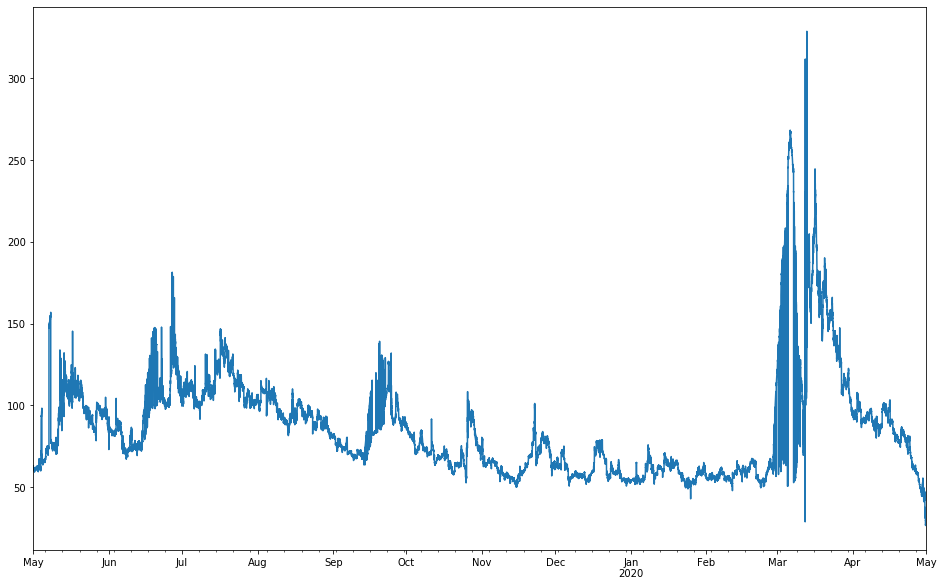

In [380]:
capi_vxbt_df['vxbt'].interpolate().plot()

In [381]:
capi_vxbt_df['vxbt_clean'] = capi_vxbt_df['vxbt'].interpolate()

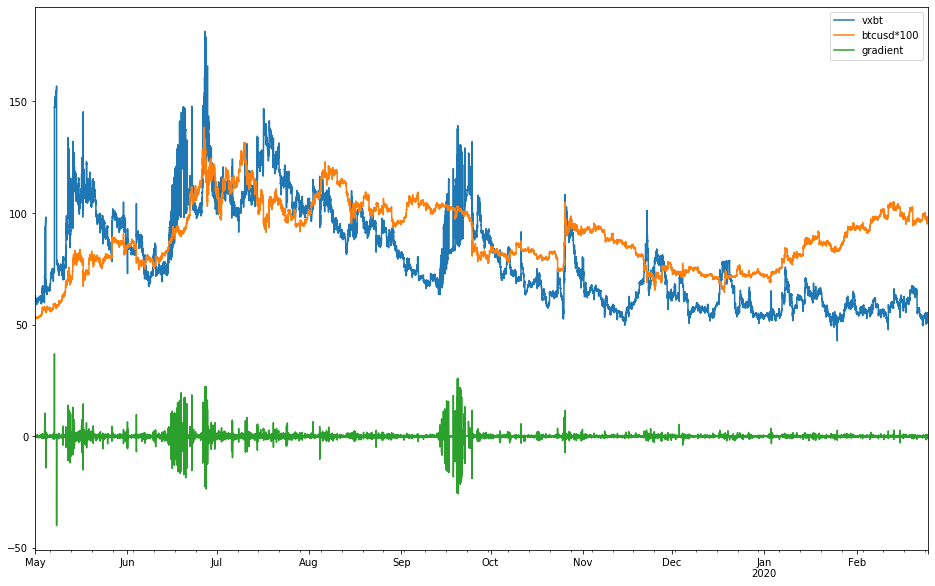

In [382]:
first = '2019-05-01 00:00:00'
last = '2020-02-25 00:00:00'

plot_df = pd.DataFrame()
plot_df['vxbt'] = capi_vxbt_df['vxbt_clean'].loc[first:last]
plot_df['btcusd*100'] = btc_index_dbit_df.loc[first:last] / 100
plot_df['gradient'] = np.gradient(plot_df['vxbt'])
plot_df.plot()

In [384]:
plot_df['gradient'].sort_values()

2019-05-08 04:35:00+00:00   -40.009641
2019-05-08 04:30:00+00:00   -38.991075
2019-09-20 00:15:00+00:00   -25.816343
2019-09-20 00:30:00+00:00   -25.622182
2019-09-19 20:40:00+00:00   -25.523483
                               ...    
2019-09-20 00:25:00+00:00    25.549131
2019-09-19 20:30:00+00:00    25.706883
2019-09-19 23:55:00+00:00    25.897850
2019-09-20 00:00:00+00:00    25.964503
2019-05-07 11:05:00+00:00    36.869478
Name: gradient, Length: 86401, dtype: float64

***

## Regression Models

### Data Cleaning

Select a 300-day time range where each series has clean data available:

In [386]:
start_date = pd.to_datetime('2019-05-01')
end_date = pd.to_datetime('2020-02-25')

series_btc = btc_index_dbit_df.loc[start_date:end_date]
series_sentiment = sentiment_time['smooth'].loc[start_date:end_date]
series_volume = tweet_volume['smooth'].loc[start_date:end_date]
series_indices = capi_vxbt_df['vxbt_clean'].loc[start_date:end_date]
series_gtrend = gtrend_df['bitcoin_ewm'].loc[start_date:end_date]

In [387]:
series_gtrend

date
2019-05-01 00:00:00+00:00    69.000000
2019-05-01 00:05:00+00:00    68.870000
2019-05-01 00:10:00+00:00    68.740000
2019-05-01 00:15:00+00:00    68.610000
2019-05-01 00:20:00+00:00    68.480000
                               ...    
2020-02-24 23:40:00+00:00    59.223280
2020-02-24 23:45:00+00:00    59.249865
2020-02-24 23:50:00+00:00    59.276451
2020-02-24 23:55:00+00:00    59.303036
2020-02-25 00:00:00+00:00    59.329621
Freq: 5T, Name: bitcoin_ewm, Length: 86401, dtype: float64

Plot narrowed down time series:

Text(0.5, 0.98, 'Time Series')

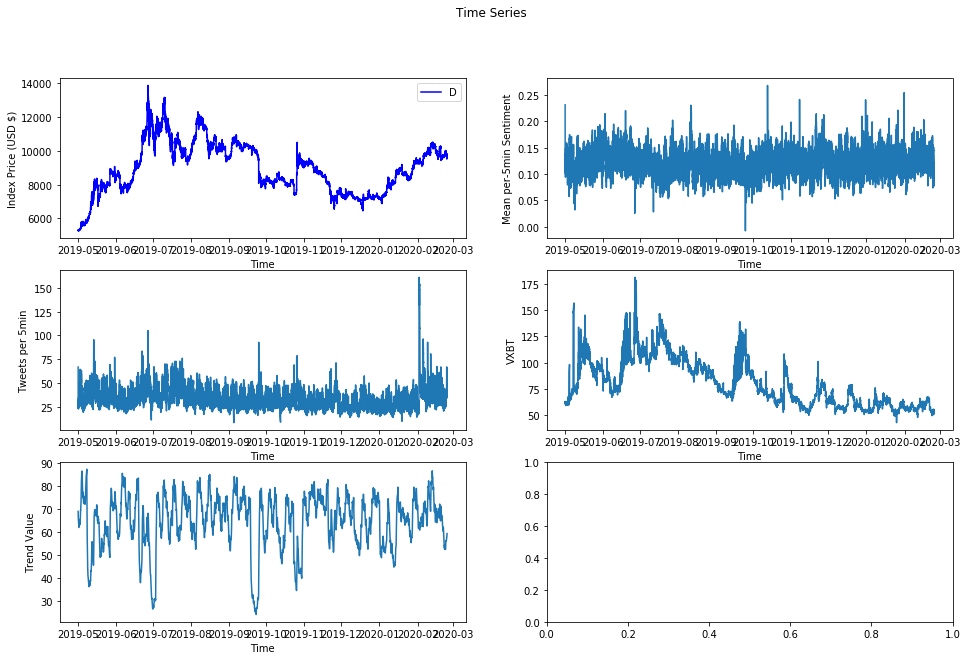

In [388]:
fig, ax =  plt.subplots(3,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Deribit')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Index Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean per-5min Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per 5min')

ax[1][1].plot(series_indices)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('VXBT')

ax[2][0].plot(series_gtrend)
ax[2][0].set_xlabel('Time')
ax[2][0].set_ylabel('Trend Value')

fig.suptitle('Time Series')

In [389]:
data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_gtrend, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend', 'index']
data

,vxbt,tweet_vol,sentiment,gtrend,index
2019-05-01 00:00:00+00:00,62.345296,67.000000,0.231404,69.000000,5269.46
2019-05-01 00:05:00+00:00,62.717271,48.280000,0.120887,68.870000,5268.33
2019-05-01 00:10:00+00:00,62.746164,40.251599,0.127315,68.740000,5272.10
2019-05-01 00:15:00+00:00,62.029956,37.373291,0.133581,68.610000,5277.00
2019-05-01 00:20:00+00:00,62.481541,35.653653,0.135679,68.480000,5289.70
...,...,...,...,...,...
2020-02-24 23:40:00+00:00,54.950495,37.020644,0.109370,59.223280,9634.59
2020-02-24 23:45:00+00:00,54.855551,36.172902,0.111851,59.249865,9648.86
2020-02-24 23:50:00+00:00,54.614673,35.159602,0.117518,59.276451,9657.82
2020-02-24 23:55:00+00:00,55.222533,34.839633,0.114410,59.303036,9673.74


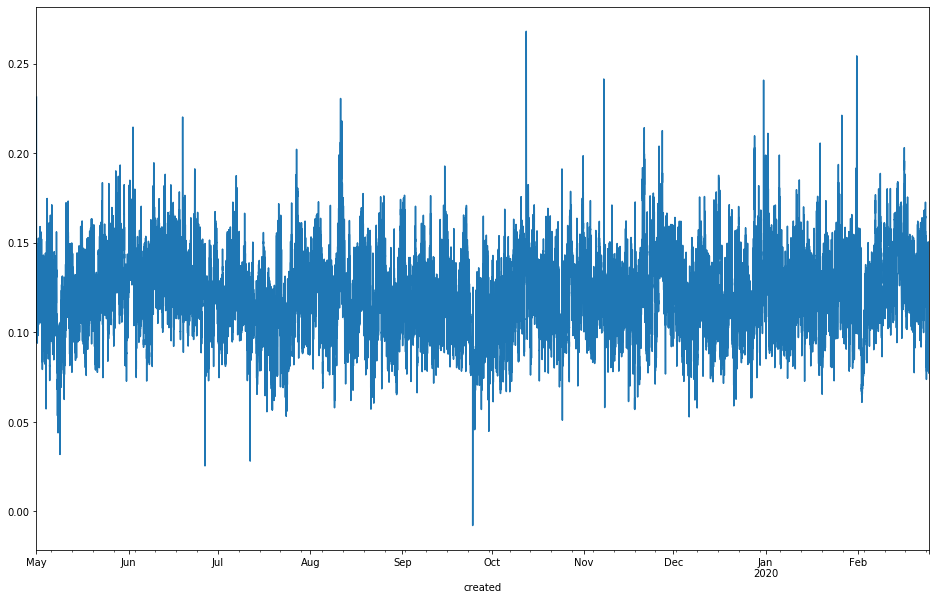

In [458]:
sentiment_time['smooth'].loc[start_date:end_date].plot()

In [390]:
# Backup
data.to_csv('../datasets/ready_data.csv')

In [19]:
# Restore
data = pd.read_csv('../datasets/ready_data.csv')
data['timestamp'] = pd.to_datetime(data['Unnamed: 0'])
data = data.drop('Unnamed: 0', axis=1).set_index('timestamp')
data

,vxbt,tweet_vol,sentiment,gtrend,index
timestamp,,,,,
2019-05-01 00:00:00+00:00,62.345296,67.000000,0.231404,69.000000,5269.46
2019-05-01 00:05:00+00:00,62.717271,48.280000,0.120887,68.870000,5268.33
2019-05-01 00:10:00+00:00,62.746164,40.251599,0.127315,68.740000,5272.10
2019-05-01 00:15:00+00:00,62.029956,37.373291,0.133581,68.610000,5277.00
2019-05-01 00:20:00+00:00,62.481541,35.653653,0.135679,68.480000,5289.70
...,...,...,...,...,...
2020-02-24 23:40:00+00:00,54.950495,37.020644,0.109370,59.223280,9634.59
2020-02-24 23:45:00+00:00,54.855551,36.172902,0.111851,59.249865,9648.86
2020-02-24 23:50:00+00:00,54.614673,35.159602,0.117518,59.276451,9657.82


## Classification: predictive signals for VXBT

### Directionalise

Assign each signal a direction for each time interval (http://users.auth.gr/passalis/assets/pdf/confs/2017_CBI_CNNLOB.pdf)

In [20]:
import seaborn as sns
import datetime

In [131]:
norm_data = (data-data.min())/(data.max()-data.min())
norm_data['vxbt_prev'] = norm_data['vxbt'].shift(1)
norm_data['tweet_vol_prev'] = norm_data['tweet_vol'].shift(1)
norm_data['sentiment_prev'] = norm_data['sentiment'].shift(1)
norm_data['gtrend_prev'] = norm_data['gtrend'].shift(1)
norm_data['index_prev'] = norm_data['index'].shift(1)
norm_data

,vxbt,tweet_vol,sentiment,gtrend,index,vxbt_prev,tweet_vol_prev,sentiment_prev,gtrend_prev,index_prev
timestamp,,,,,,,,,,
2019-05-01 00:00:00+00:00,0.141645,0.382659,0.866818,0.709731,0.000132,NaN,NaN,NaN,NaN,NaN
2019-05-01 00:05:00+00:00,0.144328,0.259329,0.466405,0.707677,0.000000,0.141645,0.382659,0.866818,0.709731,0.000132
2019-05-01 00:10:00+00:00,0.144536,0.206436,0.489696,0.705622,0.000439,0.144328,0.259329,0.466405,0.707677,0.000000
2019-05-01 00:15:00+00:00,0.139372,0.187474,0.512395,0.703568,0.001011,0.144536,0.206436,0.489696,0.705622,0.000439
2019-05-01 00:20:00+00:00,0.142628,0.176144,0.519997,0.701513,0.002491,0.139372,0.187474,0.512395,0.703568,0.001011
...,...,...,...,...,...,...,...,...,...,...
2020-02-24 23:40:00+00:00,0.088323,0.185150,0.424679,0.555222,0.508954,0.086179,0.191201,0.400869,0.554802,0.509572
2020-02-24 23:45:00+00:00,0.087639,0.179565,0.433667,0.555642,0.510617,0.088323,0.185150,0.424679,0.555222,0.508954
2020-02-24 23:50:00+00:00,0.085902,0.172889,0.454201,0.556062,0.511662,0.087639,0.179565,0.433667,0.555642,0.510617


In [22]:
def assign_direction(row, threshold):
    if row[0] > row[1] * (1 + threshold):
        return 1
    elif row[0] < row[1] * (1 - threshold):
        return -1
    else:
        return 0

In [93]:
t_min = 0.0004
t_max = 0.0006
t_step = 0.00001

t_list = list()
t_avg = list()
for t_val in np.arange(t_min, t_max, t_step):
    t_list.append(t_val)
    norm_data['gtrend_direction'] = norm_data[['gtrend', 'gtrend_prev']].apply(assign_direction, axis=1, threshold=t_val)
    t_avg.append(abs(norm_data['gtrend_direction'].value_counts() - len(norm_data['gtrend_direction'])/3).mean())

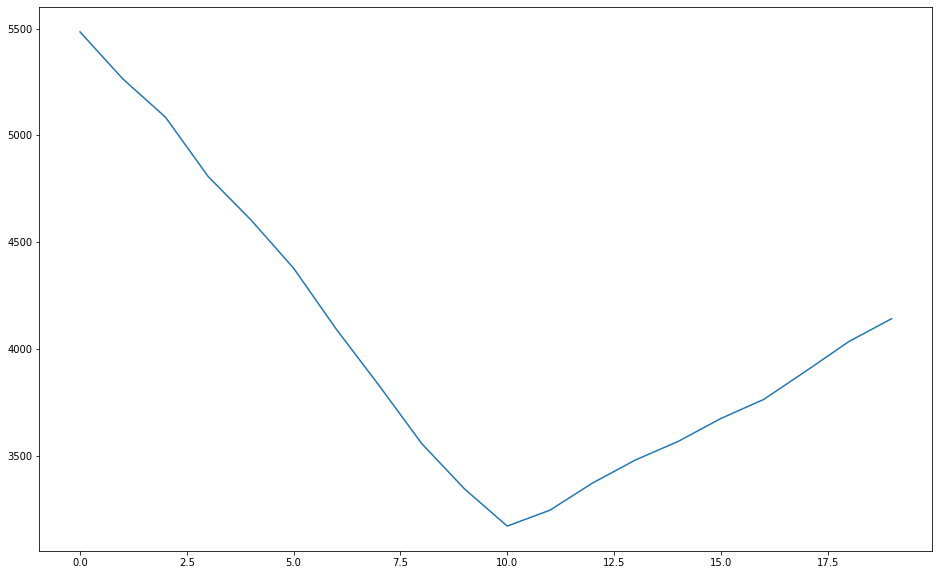

In [94]:
plt.plot(t_avg)

In [95]:
t_optimal = t_list[t_avg.index(min(t_avg))]
t_optimal

0.0005000000000000002

In [97]:
norm_data['vxbt_direction'] = norm_data[['vxbt', 'vxbt_prev']].apply(assign_direction, axis=1, threshold=0.0012)
norm_data['tweet_vol_direction'] = norm_data[['tweet_vol', 'tweet_vol_prev']].apply(assign_direction, axis=1, threshold=0.014)
norm_data['sentiment_direction'] = norm_data[['sentiment', 'sentiment_prev']].apply(assign_direction, axis=1, threshold=0.017)
norm_data['index_direction'] = norm_data[['index', 'index_prev']].apply(assign_direction, axis=1, threshold=0.0012)
norm_data['gtrend_direction'] = norm_data[['gtrend', 'gtrend_prev']].apply(assign_direction, axis=1, threshold=0.0005)

direction_df = norm_data.copy().filter(['vxbt_direction', 'tweet_vol_direction', 'sentiment_direction', 'gtrend_direction', 'index_direction'])
direction_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,gtrend_direction,index_direction
timestamp,,,,,
2020-02-25 00:00:00+00:00,0,1,-1,1,-1
2020-02-24 23:55:00+00:00,1,0,-1,1,1
2020-02-24 23:50:00+00:00,-1,-1,1,1,1
2020-02-24 23:45:00+00:00,-1,-1,1,1,1
2020-02-24 23:40:00+00:00,1,-1,1,1,-1
...,...,...,...,...,...
2019-05-01 00:20:00+00:00,1,-1,0,-1,1
2019-05-01 00:15:00+00:00,-1,-1,1,-1,1
2019-05-01 00:10:00+00:00,1,-1,1,-1,1


In [98]:
print(direction_df['vxbt_direction'].value_counts())
print(direction_df['tweet_vol_direction'].value_counts())
print(direction_df['sentiment_direction'].value_counts())
print(direction_df['gtrend_direction'].value_counts())
print(direction_df['index_direction'].value_counts())

 1    31879
 0    29946
-1    24547
Name: vxbt_direction, dtype: int64
-1    39011
 0    29012
 1    18349
Name: tweet_vol_direction, dtype: int64
-1    29436
 0    29087
 1    27849
Name: sentiment_direction, dtype: int64
-1    33552
 0    28704
 1    24116
Name: gtrend_direction, dtype: int64
 0    29010
 1    28838
-1    28524
Name: index_direction, dtype: int64


Backup in case of future kernel crash

In [99]:
direction_df.to_csv('../datasets/direction.csv')

In [ ]:
# Restore
direction_df = pd.read_csv('../datasets/direction.csv')
direction_df.index = norm_data.index

In [168]:
direction_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,gtrend_direction,index_direction
timestamp,,,,,
2019-05-01 00:00:00+00:00,0,0,0,0,0
2019-05-01 00:05:00+00:00,1,-1,-1,-1,-1
2019-05-01 00:10:00+00:00,1,-1,1,-1,1
2019-05-01 00:15:00+00:00,-1,-1,1,-1,1
2019-05-01 00:20:00+00:00,1,-1,0,-1,1
...,...,...,...,...,...
2020-02-24 23:40:00+00:00,1,-1,1,1,-1
2020-02-24 23:45:00+00:00,-1,-1,1,1,1
2020-02-24 23:50:00+00:00,-1,-1,1,1,1


### Plots

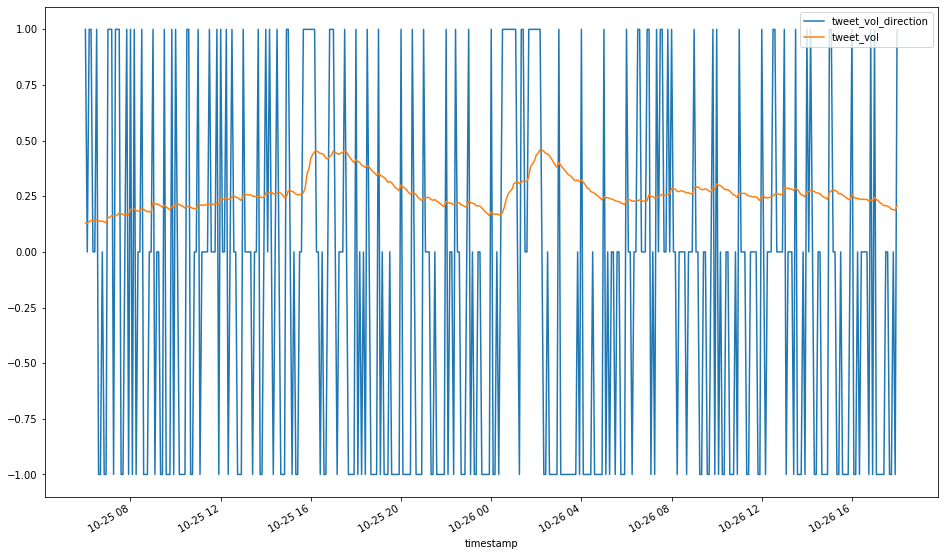

In [132]:
start = '2019-10-25 06:00:00'
finish = '2019-10-26 18:00:00'

dir_val_df = pd.DataFrame()
dir_val_df['tweet_vol_direction'] = direction_df['tweet_vol_direction']
dir_val_df['tweet_vol'] = norm_data['tweet_vol']
dir_val_df.loc[start:finish].plot()

### Data prep

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

import eli5
from eli5.sklearn import PermutationImportance

In [133]:
logreg_df = direction_df.copy().sort_index(ascending=False)
logreg_df['vxbt_direction_next'] = logreg_df['vxbt_direction'].shift(1)
logreg_df = logreg_df.dropna()
logreg_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,gtrend_direction,index_direction,vxbt_direction_next
timestamp,,,,,,
2020-02-24 23:55:00+00:00,1,0,-1,1,1,0.0
2020-02-24 23:50:00+00:00,-1,-1,1,1,1,1.0
2020-02-24 23:45:00+00:00,-1,-1,1,1,1,-1.0
2020-02-24 23:40:00+00:00,1,-1,1,1,-1,-1.0
2020-02-24 23:35:00+00:00,-1,0,1,1,0,1.0
...,...,...,...,...,...,...
2019-05-01 00:20:00+00:00,1,-1,0,-1,1,1.0
2019-05-01 00:15:00+00:00,-1,-1,1,-1,1,1.0
2019-05-01 00:10:00+00:00,1,-1,1,-1,1,-1.0


In [136]:
test_train_ratio = 0.1
split_index = int(direction_df.shape[0] * test_train_ratio)

X_train = logreg_df[['tweet_vol_direction', 'sentiment_direction', 'gtrend_direction', 'index_direction', 'vxbt_direction']].iloc[split_index:]
y_train = logreg_df[['vxbt_direction_next']].iloc[split_index:]

X_test = logreg_df[['tweet_vol_direction', 'sentiment_direction', 'gtrend_direction', 'index_direction', 'vxbt_direction']].iloc[:split_index]
y_test = logreg_df[['vxbt_direction_next']].iloc[:split_index]

X_train

,tweet_vol_direction,sentiment_direction,gtrend_direction,index_direction,vxbt_direction
timestamp,,,,,
2020-01-25 23:45:00+00:00,-1,0,0,0,1
2020-01-25 23:40:00+00:00,-1,1,0,0,1
2020-01-25 23:35:00+00:00,-1,1,0,0,1
2020-01-25 23:30:00+00:00,-1,0,0,0,1
2020-01-25 23:25:00+00:00,0,0,0,1,1
...,...,...,...,...,...
2019-05-01 00:20:00+00:00,-1,0,-1,1,1
2019-05-01 00:15:00+00:00,-1,1,-1,1,-1
2019-05-01 00:10:00+00:00,-1,1,-1,1,1


In [138]:
y_test

,vxbt_direction_next
timestamp,
2020-02-24 23:55:00+00:00,0.0
2020-02-24 23:50:00+00:00,1.0
2020-02-24 23:45:00+00:00,-1.0
2020-02-24 23:40:00+00:00,-1.0
2020-02-24 23:35:00+00:00,1.0
...,...
2020-01-26 00:10:00+00:00,1.0
2020-01-26 00:05:00+00:00,1.0
2020-01-26 00:00:00+00:00,-1.0


### Models

#### Logistic Regression: Univariate

In [139]:
samples_in_window = 24

X_train_window_uv = []
y_train_window_uv = []

X_test_window_uv = []
y_test_window_uv = []

for i in range(0, X_train.shape[0] - samples_in_window):
    X_train_window_uv.append(X_train['vxbt_direction'].iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_train_window_uv = y_train['vxbt_direction_next'].iloc[0:y_train.shape[0] - samples_in_window].to_numpy()

for i in range(0, X_test.shape[0] - samples_in_window):
    X_test_window_uv.append(X_test['vxbt_direction'].iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_test_window_uv = y_test['vxbt_direction_next'].iloc[0:y_test.shape[0] - samples_in_window].to_numpy()

In [479]:
len(X_train_window_uv), len(y_train_window_uv), len(X_test_window_uv), len(y_test_window_uv)

(77684, 77684, 8587, 8587)

In [480]:
logreg_uv = LogisticRegression().fit(X_train_window_uv, y_train_window_uv)

y_test_window_predicted_uv = logreg_uv.predict(X_test_window_uv)

Accuracy : 37.69651799231396 

F1 Score : 33.05565898373678 

Confusion Matrix: 
 Predicted  -1     0     1
Actual                   
-1         73  1087  1275
 0         28  1328  1034
 1         92  1834  1836


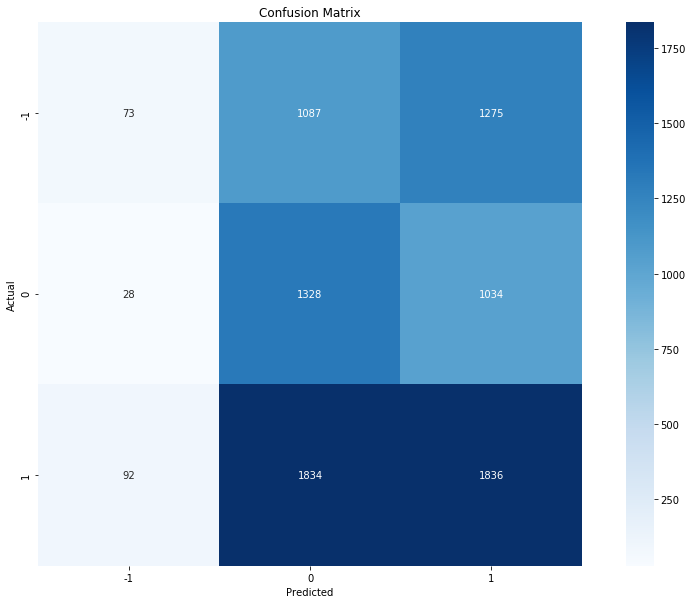

In [481]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_uv, y_test_window_predicted_uv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_uv, y_test_window_predicted_uv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_uv, y_test_window_predicted_uv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [482]:
feature_names_uv = [f'vxbt,t-{i}' for i in range(1, 50)]

In [483]:
importances_lruv = permutation_importance(logreg_uv, X_test_window_uv, y_test_window_uv)

importances_lruv_mean = dict(zip(feature_names_uv, importances_lruv['importances_mean']))
sorted_im_lruv_mean = {k: v for k, v in sorted(importances_lruv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_lruv_mean, indent=1))

{
 "vxbt,t-1": 0.010923488994992403,
 "vxbt,t-2": 0.004728077326190727,
 "vxbt,t-8": 0.00223593804588329,
 "vxbt,t-20": 0.0021194829393268557,
 "vxbt,t-4": 0.0018865727262140197,
 "vxbt,t-23": 0.001723535577035018,
 "vxbt,t-6": 0.001420752299988337,
 "vxbt,t-33": 0.0008384767672062199,
 "vxbt,t-21": 0.0006288575754046621,
 "vxbt,t-32": 0.0004658204262256493,
 "vxbt,t-12": 0.00018632817049025753,
 "vxbt,t-15": 2.329102131125582e-05,
 "vxbt,t-44": -1.1102230246251566e-17,
 "vxbt,t-19": -0.00011645510655644564,
 "vxbt,t-45": -0.0001630371491790128,
 "vxbt,t-16": -0.0001630371491790239,
 "vxbt,t-38": -0.00020961919180157996,
 "vxbt,t-22": -0.00027949225573543625,
 "vxbt,t-47": -0.0003260742983580034,
 "vxbt,t-10": -0.00034936531966929253,
 "vxbt,t-29": -0.00046582042622571594,
 "vxbt,t-31": -0.00046582042622571594,
 "vxbt,t-35": -0.0004891114475369829,
 "vxbt,t-30": -0.000489111447537005,
 "vxbt,t-17": -0.0005124024688482831,
 "vxbt,t-9": -0.0006288575754046955,
 "vxbt,t-11": -0.0006754396

#### Gradient Boosting Classifier: Univariate

In [484]:
gbc_uv = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_window_uv, y_train_window_uv)

y_test_window_predicted_uv = gbc_uv.predict(X_test_window_uv)

Accuracy : 43.92686619308257 

F1 Score : 37.819661923305944 

Confusion Matrix: 
 Predicted   -1    0     1
Actual                   
-1         129  437  1869
 0          58  839  1493
 1         146  812  2804


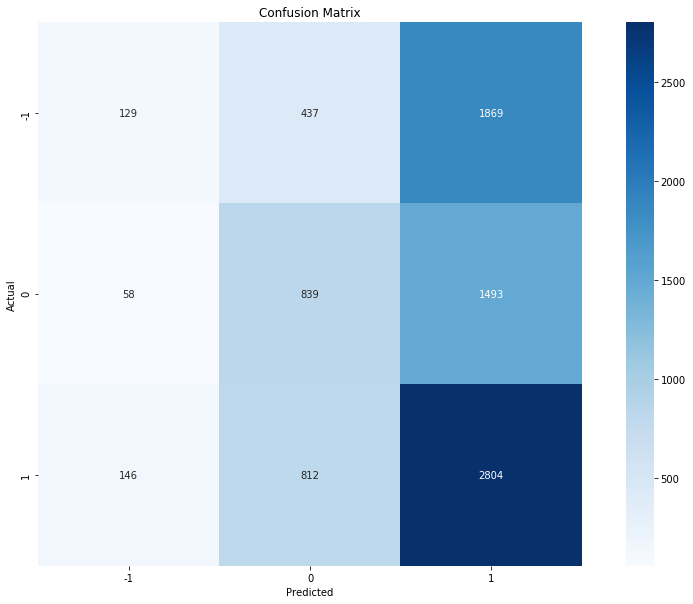

In [485]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_uv, y_test_window_predicted_uv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_uv, y_test_window_predicted_uv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_uv, y_test_window_predicted_uv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [486]:
importances_gbcuv = permutation_importance(gbc_uv, X_test_window_uv, y_test_window_uv)

importances_gbcuv_mean = dict(zip(feature_names_uv, importances_gbcuv['importances_mean']))
sorted_im_gbcuv_mean = {k: v for k, v in sorted(importances_gbcuv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_gbcuv_mean, indent=1))

{
 "vxbt,t-1": 0.008850588098288092,
 "vxbt,t-4": 0.0022825200885058573,
 "vxbt,t-47": 0.001444043321299604,
 "vxbt,t-31": 0.001420752299988337,
 "vxbt,t-12": 0.0012577151508093355,
 "vxbt,t-14": 0.0012111331081867682,
 "vxbt,t-5": 0.0010713869803190557,
 "vxbt,t-49": 0.0010248049376964884,
 "vxbt,t-28": 0.0009083498311400762,
 "vxbt,t-18": 0.0007918947245836528,
 "vxbt,t-23": 0.0007918947245836416,
 "vxbt,t-26": 0.0007686037032723636,
 "vxbt,t-3": 0.0007686037032723525,
 "vxbt,t-42": 0.000582275532782095,
 "vxbt,t-9": 0.0004891114475369607,
 "vxbt,t-32": 0.0004891114475369607,
 "vxbt,t-33": 0.00044252940491437134,
 "vxbt,t-44": 0.00039594736229180415,
 "vxbt,t-6": 0.00034936531966924813,
 "vxbt,t-43": 0.00030278327704666983,
 "vxbt,t-2": 0.0002794922557354029,
 "vxbt,t-40": 9.316408524511211e-05,
 "vxbt,t-41": 9.316408524510101e-05,
 "vxbt,t-48": -2.329102131130023e-05,
 "vxbt,t-30": -4.658204262258936e-05,
 "vxbt,t-34": -0.00011645510655644564,
 "vxbt,t-16": -0.00013974612786772368,


### Multivariate

#### Logistic Regression: Multivariate

In [143]:
samples_in_window = 25

X_train_window_mv = []
y_train_window_mv = []

X_test_window_mv = []
y_test_window_mv = []

for i in range(0, X_train.shape[0] - samples_in_window):
    X_train_window_mv.append(X_train.iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_train_window_mv = y_train['vxbt_direction_next'].iloc[0:y_train.shape[0] - samples_in_window].to_numpy()

for i in range(0, X_test.shape[0] - samples_in_window):
    X_test_window_mv.append(X_test.iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_test_window_mv = y_test['vxbt_direction_next'].iloc[0:y_test.shape[0] - samples_in_window].to_numpy()

In [144]:
len(X_train_window_mv), len(y_train_window_mv), len(X_test_window_mv), len(y_test_window_mv)

(77709, 77709, 8612, 8612)

In [460]:
logreg_mv = LogisticRegression().fit(X_train_window_mv, y_train_window_mv)

y_test_window_predicted_mv = logreg_mv.predict(X_test_window_mv)

Accuracy : 37.4868988005124 

F1 Score : 35.426157145676655 

Confusion Matrix: 
 Predicted   -1     0     1
Actual                    
-1         383   909  1329
 0         259  1106  1365
 1         406  1100  1730


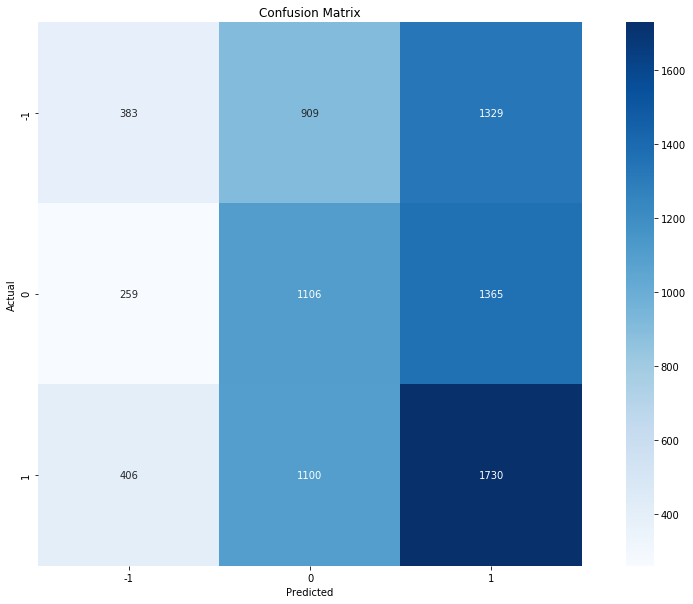

In [461]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_mv, y_test_window_predicted_mv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_mv, y_test_window_predicted_mv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_mv, y_test_window_predicted_mv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [145]:
feature_names_mv = [f'{col},t-{i}' for i in range(0, samples_in_window) for col in X_train.columns]
feature_names_mv

['tweet_vol_direction,t-0',
 'sentiment_direction,t-0',
 'gtrend_direction,t-0',
 'index_direction,t-0',
 'vxbt_direction,t-0',
 'tweet_vol_direction,t-1',
 'sentiment_direction,t-1',
 'gtrend_direction,t-1',
 'index_direction,t-1',
 'vxbt_direction,t-1',
 'tweet_vol_direction,t-2',
 'sentiment_direction,t-2',
 'gtrend_direction,t-2',
 'index_direction,t-2',
 'vxbt_direction,t-2',
 'tweet_vol_direction,t-3',
 'sentiment_direction,t-3',
 'gtrend_direction,t-3',
 'index_direction,t-3',
 'vxbt_direction,t-3',
 'tweet_vol_direction,t-4',
 'sentiment_direction,t-4',
 'gtrend_direction,t-4',
 'index_direction,t-4',
 'vxbt_direction,t-4',
 'tweet_vol_direction,t-5',
 'sentiment_direction,t-5',
 'gtrend_direction,t-5',
 'index_direction,t-5',
 'vxbt_direction,t-5',
 'tweet_vol_direction,t-6',
 'sentiment_direction,t-6',
 'gtrend_direction,t-6',
 'index_direction,t-6',
 'vxbt_direction,t-6',
 'tweet_vol_direction,t-7',
 'sentiment_direction,t-7',
 'gtrend_direction,t-7',
 'index_direction,t-7',

In [411]:
importances_lrmv = permutation_importance(logreg_mv, X_test_window_mv, y_test_window_mv)

importances_lrmv_mean = dict(zip(feature_names_mv, importances_lrmv['importances_mean']))
sorted_im_lrmv_mean = {k: v for k, v in sorted(importances_lrmv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_lrmv_mean, indent=1))

{
 "index_direction,t-2": 0.007243507627809486,
 "vxbt_direction,t-1": 0.0052171887737277435,
 "tweet_vol_direction,t-1": 0.003214160940957256,
 "sentiment_direction,t-44": 0.0026784674507977168,
 "tweet_vol_direction,t-4": 0.0022825200885058794,
 "sentiment_direction,t-11": 0.002259229067194601,
 "vxbt_direction,t-6": 0.002166064981949467,
 "vxbt_direction,t-38": 0.002096191918015611,
 "index_direction,t-19": 0.0020496098753930323,
 "tweet_vol_direction,t-9": 0.0020030278327704655,
 "vxbt_direction,t-22": 0.0020030278327704655,
 "sentiment_direction,t-40": 0.0018632817049027638,
 "vxbt_direction,t-16": 0.0018632817049027528,
 "vxbt_direction,t-2": 0.0016769535344124842,
 "vxbt_direction,t-47": 0.001653662513101195,
 "sentiment_direction,t-7": 0.001630371491789917,
 "vxbt_direction,t-46": 0.0015139163852334824,
 "sentiment_direction,t-29": 0.0014906253639222044,
 "tweet_vol_direction,t-31": 0.0014207522999883592,
 "index_direction,t-24": 0.001397461278677059,
 "vxbt_direction,t-41": 0.

#### Gradient Boosting Classifier: Multivariate

In [32]:
samples_in_window = 50

X_df = logreg_df.drop('vxbt_direction_next', axis=1)
y_df = logreg_df['vxbt_direction_next']

X_window_mv = []
y_window_mv = []

for i in range(0, X_df.shape[0] - samples_in_window):
    X_window_mv.append(X_df.iloc[i:i + samples_in_window].to_numpy().ravel())

y_window_mv = y_df.iloc[0:y_df.shape[0] - samples_in_window].to_numpy()

len(X_window_mv), len(y_window_mv), len(X_window_mv[0])

(86321, 86321, 200)

In [36]:
y_window_mv

array([0., 1., 1., ..., 1., 1., 0.])

In [146]:
gbc_cv = GradientBoostingClassifier()
gbc_cv.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Accuracy of the GBM on test set: 0.438
              precision    recall  f1-score   support

        -1.0       0.39      0.06      0.11      2442
         0.0       0.39      0.47      0.42      2394
         1.0       0.47      0.66      0.55      3776

    accuracy                           0.44      8612
   macro avg       0.42      0.40      0.36      8612
weighted avg       0.42      0.44      0.39      8612



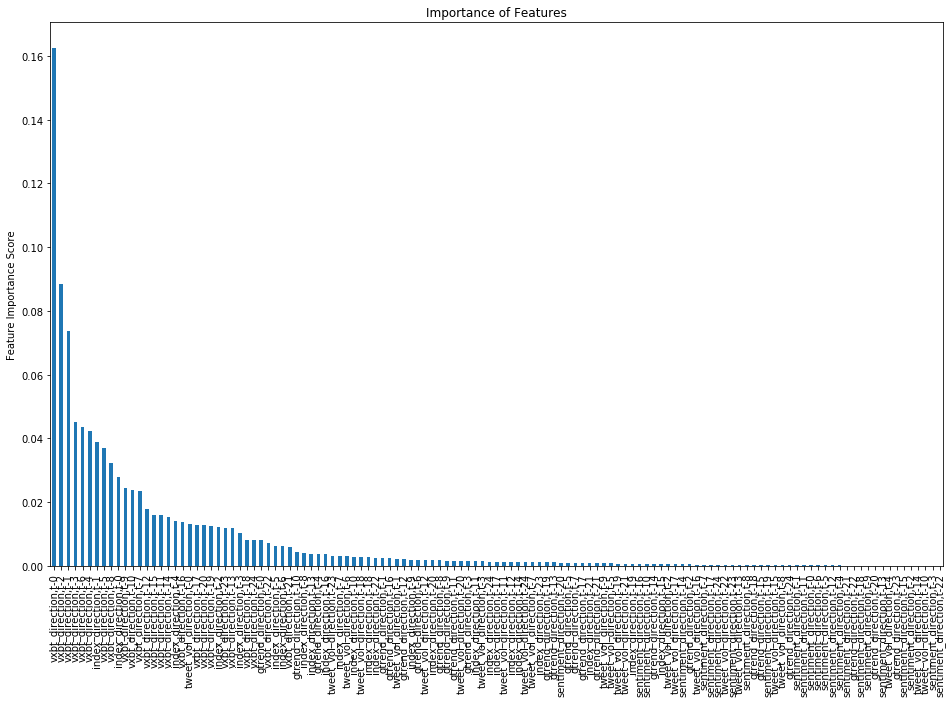

In [147]:
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10)
baseline.fit(X_train_window_mv, y_train_window_mv)

predictors = list(X_window_mv)
feat_imp = pd.Series(baseline.feature_importances_, feature_names_mv).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test_window_mv, y_test_window_mv)))
pred = baseline.predict(X_test_window_mv)
print(classification_report(y_test_window_mv, pred))

In [149]:
p_test3 = {'learning_rate':[0.01, 0.05, 0.1, 0.25, 0.5], 'n_estimators':[100, 250, 500, 750, 1000]}

#tuning = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
#            param_grid = p_test3, scoring='accuracy',n_jobs=1,iid=False, cv=5)

tuning = RandomizedSearchCV(estimator=GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10),
                            param_distributions = p_test3, scoring='accuracy', n_jobs=-1, n_iter=10, iid=False, cv=5)

tuning.fit(X_train_window_mv, y_train_window_mv)
tuning.best_params_, tuning.best_score_, tuning.cv_results_

/home/fp361/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'n_estimators': 500, 'learning_rate': 0.01},
 0.4432431642226794,
 {'mean_fit_time': array([ 50.43050842,  53.73543172, 255.46370735, 252.46813884,
         126.97108655, 127.60109329, 253.65266466, 500.27555594,
         491.07480478, 125.23008552]),
  'std_fit_time': array([ 1.50276417,  0.74586287,  3.27418775,  2.35790484,  1.36557542,
          0.91463145,  2.61723462,  3.48010831, 15.03675665,  1.686724  ]),
  'mean_score_time': array([0.29938598, 0.30650282, 1.34160285, 1.45258832, 0.64868565,
         0.72395272, 1.29999752, 2.50613117, 2.29742398, 0.72411733]),
  'std_score_time': array([0.0156147 , 0.01581167, 0.07755636, 0.18760509, 0.01697065,
         0.05923146, 0.05832042, 0.08095184, 0.4549666 , 0.0992408 ]),
  'param_n_estimators': masked_array(data=[100, 100, 500, 500, 250, 250, 500, 1000, 1000, 250],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),


In [150]:
lr = tuning.best_params_['learning_rate']
ne = tuning.best_params_['n_estimators']

p_test2 = {'max_depth':[2, 3, 4, 5, 6, 7]}

tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=lr, n_estimators=ne, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train_window_mv, y_train_window_mv)
#tuning.grid_scores_,
tuning.best_params_, tuning.best_score_

/home/fp361/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 4}, 0.4432431642226794)

Accuracy of the GBM on test set: 0.434
              precision    recall  f1-score   support

        -1.0       0.37      0.03      0.06      2442
         0.0       0.38      0.48      0.43      2394
         1.0       0.47      0.66      0.55      3776

    accuracy                           0.43      8612
   macro avg       0.41      0.39      0.34      8612
weighted avg       0.42      0.43      0.38      8612



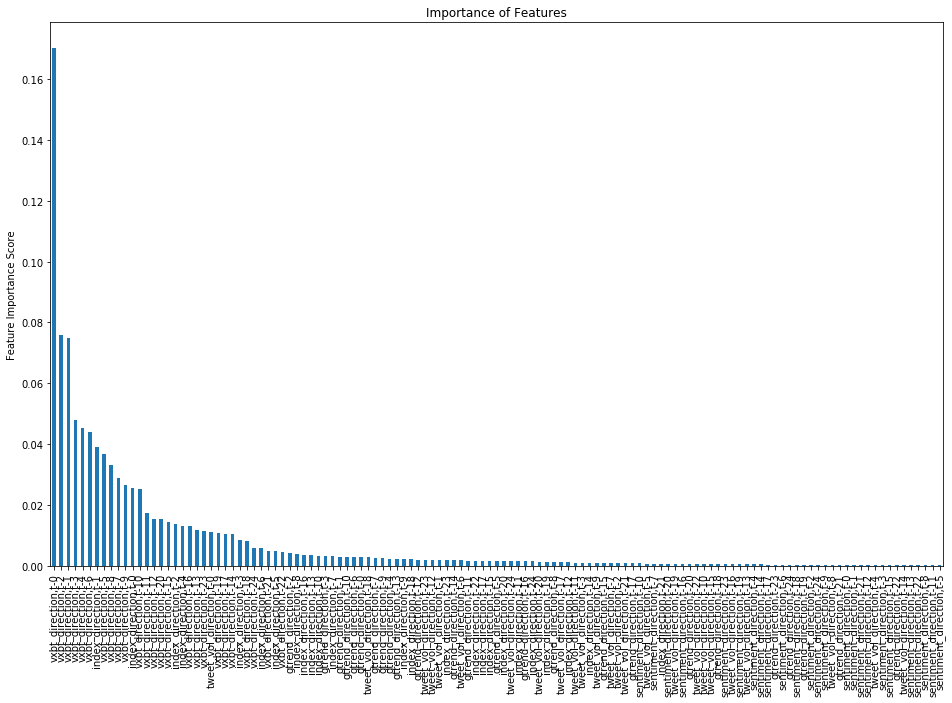

In [151]:
md = tuning.best_params_['max_depth']

model1 = GradientBoostingClassifier(learning_rate=lr, n_estimators=ne, max_depth=md, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train_window_mv, y_train_window_mv)

#predictors=list(X_train)

feat_imp = pd.Series(model1.feature_importances_, feature_names_mv).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test_window_mv, y_test_window_mv)))
pred = model1.predict(X_test_window_mv)
print(classification_report(y_test_window_mv, pred))

Confusion Matrix: 
 Predicted  -1     0     1
Actual                   
-1         76   702  1664
 0         42  1156  1196
 1         87  1180  2509 


Accuracy score (training): 0.463
Accuracy score (validation): 0.434



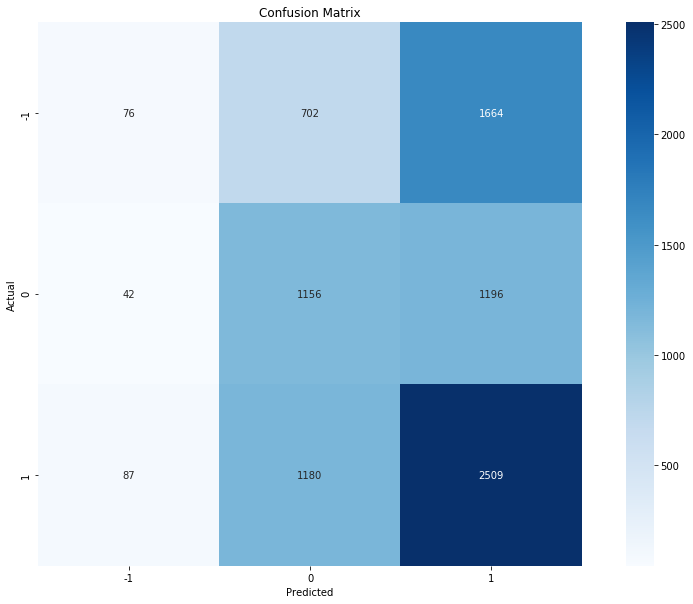

In [152]:
#gbc_mv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75, max_features=2, max_depth=2, random_state=0).fit(X_train_window_mv, y_train_window_mv)

#y_test_window_predicted_mv = gbc_mv.predict(X_test_window_mv)

classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_mv, pred, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

#print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_mv, y_test_window_predicted_mv)))
#print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_mv, y_test_window_predicted_mv, average='weighted')))
print('Confusion Matrix: \n {} \n\n'.format(cm))

print("Accuracy score (training): {0:.3f}".format(model1.score(X_train_window_mv, y_train_window_mv)))
print("Accuracy score (validation): {0:.3f}\n".format(model1.score(X_test_window_mv, y_test_window_mv)))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [159]:
perm_gbc_mv = PermutationImportance(model1, random_state=0).fit(X_test_window_mv, y_test_window_mv)

In [162]:
out1 = eli5.explain_weights(perm_gbc_mv, feature_names=feature_names_mv, top=20)
print(eli5.format_as_html(out1))
out1


    <style>
    table.eli5-weights tr:hover {
        filter: brightness(85%);
    }
</style>



    
        <p>Explained as: feature importances</p>
    

    

    

    

    

    


    

    
        
        <pre>
Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.
</pre>
    

    

    

    

    


    

    

    

    

    

    


    

    

    

    

    

    


    

    

    

    

    
        <table class="eli5-weights eli5-feature-importances" style="border-collapse: collapse; border: none; margin-top: 0em; table-layout: auto;">
    <thead>
    <tr style="border: none;">
        <th style="padding: 0 1em 0 0.5em; text-align: right; border: none;">Weig

Weight,Feature
0.0086 ± 0.0065,"vxbt_direction,t-0"
0.0021 ± 0.0018,"vxbt_direction,t-11"
0.0012 ± 0.0031,"index_direction,t-1"
0.0012 ± 0.0016,"vxbt_direction,t-10"
0.0010 ± 0.0010,"gtrend_direction,t-16"
0.0010 ± 0.0009,"gtrend_direction,t-1"
0.0010 ± 0.0007,"gtrend_direction,t-13"
0.0009 ± 0.0017,"vxbt_direction,t-21"
0.0009 ± 0.0008,"gtrend_direction,t-14"
0.0009 ± 0.0017,"gtrend_direction,t-10"


In [166]:
def filter_vxbt_index(feature_name):
    return not ('vxbt' in feature_name or 'index' in feature_name)

out2 = eli5.explain_weights(perm_gbc_mv, feature_names=feature_names_mv, top=75, feature_filter=filter_vxbt_index)
print(eli5.format_as_html(out2))
out2


    <style>
    table.eli5-weights tr:hover {
        filter: brightness(85%);
    }
</style>



    
        <p>Explained as: feature importances</p>
    

    

    

    

    

    


    

    
        
        <pre>
Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.
</pre>
    

    

    

    

    


    

    

    

    

    

    


    

    

    

    

    

    


    

    

    

    

    
        <table class="eli5-weights eli5-feature-importances" style="border-collapse: collapse; border: none; margin-top: 0em; table-layout: auto;">
    <thead>
    <tr style="border: none;">
        <th style="padding: 0 1em 0 0.5em; text-align: right; border: none;">Weig

Weight,Feature
0.0010 ± 0.0010,"gtrend_direction,t-16"
0.0010 ± 0.0009,"gtrend_direction,t-1"
0.0010 ± 0.0007,"gtrend_direction,t-13"
0.0009 ± 0.0017,"gtrend_direction,t-10"
0.0009 ± 0.0008,"gtrend_direction,t-14"
0.0007 ± 0.0008,"gtrend_direction,t-15"
0.0006 ± 0.0012,"gtrend_direction,t-12"
0.0006 ± 0.0009,"gtrend_direction,t-0"
0.0005 ± 0.0009,"gtrend_direction,t-7"
0.0005 ± 0.0007,"gtrend_direction,t-11"
